## Getting Album Recommendations from P4K

**Read User Library, sort on an audio feature and threshold, and find 2017 album recommendations from P4K based on your weighted audio features (by standard deviations and mean)**

Requirements:

Have 'sp-&-p4k_combined-2017-utf8sig-final.csv' and 'our_tracks.csv' in same directory as NB.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline


In [2]:
# Optional: Only if you don't have this.
# pip install wordcloud

In [2]:
combined_reviews_fname = 'sp-&-p4k_combined-2017-utf8sig-final.csv'

sp_p4k_2017_df = pd.read_csv(combined_reviews_fname, index_col = 0)

sp_p4k_2017_df.tail()

,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,valence,popularity,duration_ms,is_explicit,artist,best,date,genre,review,score
1058,spotify:album:7z7hGOK5ZvGQ2rCp9TyMHc,Happy Together,Mega Bog,0.4337,0.4270,0.6402,0.2764,0.1942,-7.2556,0.0519,...,0.4747,5.7778,1638435,0,Mega Bog,0,February 6 2017,Experimental,Mega Bog is the malleable rock band mastermind...,7.4000
1059,spotify:album:7zJ6TVgvzdV9HPE8KA2a7R,Hate Songs EP,Suicideyear,0.1792,0.5723,0.6933,0.5878,0.1883,-6.0307,0.0513,...,0.1758,9.5000,1548171,0,Suicideyear,0,July 28 2017,Electronic,Stepping away from his habitual trap beats and...,7.3000
1060,spotify:album:7zg9ZSOQtYLjWnvSawflg6,Born Again,The Notorious B.I.G.,0.1496,0.6924,0.7748,0.0038,0.2771,-5.6680,0.3424,...,0.6352,44.8824,4294841,17,The Notorious B.I.G.,0,March 9 2017,Rap,The half-baked 1999 release Born Again reeks o...,6.0000
1061,spotify:album:7zo4kiBFeJ6fTRJLTKo7XU,Belladonna of Sadness,Alexandra Savior,0.0671,0.5226,0.6552,0.0029,0.2239,-7.2379,0.0403,...,0.5956,41.2000,2248784,1,Alexandra Savior,0,April 19 2017,Pop/R&B,The young American singer launches her career ...,6.0000
1062,spotify:album:7zy6BF4J1cdLVZaPoTbLa7,All Blue,G Perico,0.1640,0.8337,0.6395,0.0000,0.1961,-6.9567,0.3181,...,0.5325,22.1818,1774000,11,G Perico,0,May 5 2017,Rap,While nodding to West Coast legends of the ’90...,7.9000


In [3]:
sp_p4k_2017_df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,is_explicit,best,score
count,"1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000"
mean,0.3060,0.5114,0.5958,0.2945,0.1952,-9.4285,0.0944,119.7187,0.3858,23.7076,"2,772,106.4083",2.1317,0.0696,7.2948
std,0.2482,0.1554,0.1829,0.3049,0.0890,3.9188,0.0812,13.4944,0.1701,16.4774,"1,508,422.6319",4.7577,0.2546,0.9337
min,0.0000,0.0645,0.0075,0.0000,0.0709,-36.4756,0.0270,67.0175,0.0189,0.0000,"180,442.0000",0.0000,0.0000,2.8000
25%,0.1130,0.4092,0.4769,0.0190,0.1376,-11.2794,0.0422,112.0647,0.2581,9.4018,"2,077,869.5000",0.0000,0.0000,6.8000
50%,0.2428,0.5212,0.6142,0.1735,0.1764,-8.7179,0.0595,119.8267,0.3887,22.3333,"2,510,019.0000",0.0000,0.0000,7.4000
75%,0.4479,0.6252,0.7271,0.5676,0.2276,-6.6023,0.1063,128.0343,0.5003,35.3333,"3,111,877.0000",1.0000,0.0000,7.8000
max,0.9930,0.9290,0.9852,0.9918,0.8670,-2.0892,0.4235,193.2440,0.9021,75.2000,"16,584,080.0000",24.0000,1.0000,10.0000


In [4]:
# divide loudness column by -60, divide tempo column by 200, popularity by 100

sp_p4k_2017_df['loudness'] = sp_p4k_2017_df['loudness']/(-60) # closer to 0 means louder in all positive or all negative cases

sp_p4k_2017_df['tempo'] = sp_p4k_2017_df['tempo']/(210)

sp_p4k_2017_df['popularity'] = sp_p4k_2017_df['popularity']/(100)

sp_p4k_2017_df.describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,is_explicit,best,score
count,"1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000","1,063.0000"
mean,0.3060,0.5114,0.5958,0.2945,0.1952,0.1571,0.0944,0.5701,0.3858,0.2371,"2,772,106.4083",2.1317,0.0696,7.2948
std,0.2482,0.1554,0.1829,0.3049,0.0890,0.0653,0.0812,0.0643,0.1701,0.1648,"1,508,422.6319",4.7577,0.2546,0.9337
min,0.0000,0.0645,0.0075,0.0000,0.0709,0.0348,0.0270,0.3191,0.0189,0.0000,"180,442.0000",0.0000,0.0000,2.8000
25%,0.1130,0.4092,0.4769,0.0190,0.1376,0.1100,0.0422,0.5336,0.2581,0.0940,"2,077,869.5000",0.0000,0.0000,6.8000
50%,0.2428,0.5212,0.6142,0.1735,0.1764,0.1453,0.0595,0.5706,0.3887,0.2233,"2,510,019.0000",0.0000,0.0000,7.4000
75%,0.4479,0.6252,0.7271,0.5676,0.2276,0.1880,0.1063,0.6097,0.5003,0.3533,"3,111,877.0000",1.0000,0.0000,7.8000
max,0.9930,0.9290,0.9852,0.9918,0.8670,0.6079,0.4235,0.9202,0.9021,0.7520,"16,584,080.0000",24.0000,1.0000,10.0000


In [5]:
def plotWordCloud(df_word_cloud):
    """
    Input any df with reviews in it. Generates word clout plot for their reviews.
    """
    comment_words = ''
    additional_stopwords = set(("song", "album", "record", "music", "songs", "track", "band", "sound", "s", "t", "year"))
    stopwords =  set(STOPWORDS).union(additional_stopwords)

    df_word_cloud = df_word_cloud.review

    # iterate through the csv file
    for val in df_word_cloud:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()
        tokens = [token for token in tokens if len(token) > 1]

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10, collocations=False).generate(comment_words)

    # plot the WordCloud image                       
    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

## Add column to DF to indicate if album is in Group 1, 2, 3, 4

Group 1: "favorites"
- above average popularity, above average score

Group 2: "underrated"
- below average popularity, above average score

Group 3: "overrated"
- above average popularity, below average score

Group 4: "ignorables"
- below average popularity, below average score

In [6]:
mean_score_allData = sp_p4k_2017_df.score.mean()
print(mean_score_allData)
mean_pop_allData = sp_p4k_2017_df.popularity.mean()
print(mean_pop_allData)

def label_group(row):
   if (row['popularity'] > mean_pop_allData) and (row['score'] > mean_score_allData) :
      return 'favorites'
   if (row['popularity'] <= mean_pop_allData) and (row['score'] > mean_score_allData) :
      return 'underrated'
   if (row['popularity'] > mean_pop_allData) and (row['score'] <= mean_score_allData) :
      return 'overrated'
   else:
      return 'ignorables'

sp_p4k_2017_df['group_label'] = sp_p4k_2017_df.apply(lambda row: label_group(row), axis=1)
sp_p4k_2017_df.head(5)

7.2948259642521185
0.23707562380224229


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,popularity,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label
0,spotify:album:00LS6GJwb5ZPTKS8NMAT8x,Ultramega OK,Soundgarden,0.0167,0.3555,0.8228,0.2762,0.1938,0.1379,0.0634,...,0.2353,4224568,0,Soundgarden,0,March 20 2017,Rock,"Originally released in 1988 on SST, Soundgarde...",7.3000,underrated
1,spotify:album:00MAXeszCotk3g9q8KYJlZ,Elastica,Elastica,0.0132,0.5434,0.7989,0.3546,0.1419,0.0935,0.0444,...,0.2764,2186449,1,Elastica,0,September 24 2017,Rock,"With its pithy, searing songs about sex, group...",8.5000,favorites
2,spotify:album:00RnMn3ikeVB6gdOMZ3mwQ,No Mountains in Manhattan,Wiki,0.4477,0.5967,0.7189,0.0005,0.3150,0.1117,0.3737,...,0.1840,3191839,15,Wiki,0,August 30 2017,Rap,Wiki’s new album is an acidic and vivid manife...,8.1000,underrated
3,spotify:album:02ER13KaisZo5CG2BydCWn,Americana,Ray Davies,0.4588,0.5249,0.4491,0.0010,0.1896,0.2033,0.0432,...,0.1167,3511114,0,Ray Davies,0,April 18 2017,Rock,The Kinks legend uses Americana to blaze a pat...,7.3000,underrated
4,spotify:album:02Lx6I5EsUDFIdnS3pSNNT,Rosewood Almanac,Will Stratton,0.6693,0.4786,0.3263,0.0458,0.1885,0.2018,0.0342,...,0.0767,1775810,0,Will Stratton,0,May 22 2017,Folk/Country,"With pastoral folk roots, New York singer-song...",7.0000,ignorables


## Getting Recommendations based on vector input

For our personal datasets, we can choose an audio feature, give a threshold value and specify above or below for direction. We can generate a vector of other audio features for our libraries based on this threshold. We want the audio feature, average value, and weight (assumed = 1). The weights can be changed based on the inverse of the variance of the audio features, and their relative %.

Then we get the subset of p4k data with this audio feature threshold met. Lets say valence above 0.3 for example. 

On this subset, we will apply a row function to create the distance between our library vector and the album's audio features. The distance will only use the audio features specified by our library vector, and will use the weights specified for each audio feature.

Each album will have a distance added as a variable. Sort by shortest distance to find the closest recommended albums for the user.

In [8]:
def getAlbumDistance(row, library_vector: dict):
    """
    Inputs:
    row: the album row from data frame
    library_vector: dictionary of audio feature keys, and values as average_value, weight of each key
    """
    distance = 0
    for audio_feature in library_vector:
        temp_dist = library_vector[audio_feature]['weight'] * np.power((row[audio_feature] - library_vector[audio_feature]['average_value']), 2)
        distance = distance + temp_dist
    return np.sqrt(distance)

In [9]:
def P4K_Recommended(by_audio_feature: str, threshold: float, above_threshold: bool, library_vector: dict, P4K_DF):
    """
    by_audio_feature: name of audio feature to filter pitchfork df by
    """
    # get a copy of the p4k DF based on the audio feature
    if above_threshold:
        focused_P4K_DF = P4K_DF[P4K_DF[by_audio_feature] > threshold].copy()
    else:
        focused_P4K_DF = P4K_DF[P4K_DF[by_audio_feature] <= threshold].copy()
    
    focused_P4K_DF['distance'] = focused_P4K_DF.apply(lambda row: getAlbumDistance(row, library_vector), axis=1)
    return focused_P4K_DF.sort_values('distance', ascending=True)

def P4K_Recommended_noFilter(library_vector: dict, P4K_DF):
    """
    version of P4K_Recommended that does no filtering based on audio feature. 
    Will look for album recommendations in the whole DF, for all audio features in the library_vector.
    """
    
    focused_P4K_DF = P4K_DF.copy()
    # get a copy of the p4k DF based on the audio feature
    
    focused_P4K_DF['distance'] = focused_P4K_DF.apply(lambda row: getAlbumDistance(row, library_vector), axis=1)
    return focused_P4K_DF.sort_values('distance', ascending=True)

## Library Data to get our album recommendations

In [10]:
# load in our tracks df
our_tracks_df = pd.read_csv("our_tracks.csv")

our_tracks_df.describe()


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,"1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000"
mean,35.7092,"294,673.6983",0.5475,0.5307,5.1792,-10.7760,0.5867,0.0611,0.3563,0.3700,0.1674,0.3538,118.6870
std,22.8473,"159,455.4952",0.1993,0.2428,3.5992,5.4234,0.4926,0.0595,0.3582,0.3946,0.1430,0.2395,27.3282
min,0.0000,"41,461.0000",0.0601,0.0031,0.0000,-36.8860,0.0000,0.0225,0.0000,0.0000,0.0304,0.0253,58.8300
25%,19.0000,"211,493.5000",0.4078,0.3648,2.0000,-13.0120,0.0000,0.0344,0.0259,0.0001,0.0935,0.1590,100.0188
50%,37.0000,"263,225.5000",0.5720,0.5470,5.0000,-9.5825,1.0000,0.0425,0.2145,0.1165,0.1130,0.3105,119.9985
75%,53.0000,"352,811.0000",0.7073,0.7152,8.0000,-7.0925,1.0000,0.0584,0.6923,0.8295,0.1823,0.5072,131.7322
max,94.0000,"3,815,786.0000",0.9620,0.9970,11.0000,-2.1080,1.0000,0.4930,0.9960,0.9930,0.9970,0.9750,209.5280


In [11]:
# divide loudness column by -60, divide tempo column by 200, popularity by 100

our_tracks_df['loudness'] = our_tracks_df['loudness']/(-60) # closer to 0 means louder in all positive or all negative cases

our_tracks_df['tempo'] = our_tracks_df['tempo']/(210)

our_tracks_df['popularity'] = our_tracks_df['popularity']/(100)

our_tracks_df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,"1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000","1,200.0000"
mean,0.3571,"294,673.6983",0.5475,0.5307,5.1792,0.1796,0.5867,0.0611,0.3563,0.3700,0.1674,0.3538,0.5652
std,0.2285,"159,455.4952",0.1993,0.2428,3.5992,0.0904,0.4926,0.0595,0.3582,0.3946,0.1430,0.2395,0.1301
min,0.0000,"41,461.0000",0.0601,0.0031,0.0000,0.0351,0.0000,0.0225,0.0000,0.0000,0.0304,0.0253,0.2801
25%,0.1900,"211,493.5000",0.4078,0.3648,2.0000,0.1182,0.0000,0.0344,0.0259,0.0001,0.0935,0.1590,0.4763
50%,0.3700,"263,225.5000",0.5720,0.5470,5.0000,0.1597,1.0000,0.0425,0.2145,0.1165,0.1130,0.3105,0.5714
75%,0.5300,"352,811.0000",0.7073,0.7152,8.0000,0.2169,1.0000,0.0584,0.6923,0.8295,0.1823,0.5072,0.6273
max,0.9400,"3,815,786.0000",0.9620,0.9970,11.0000,0.6148,1.0000,0.4930,0.9960,0.9930,0.9970,0.9750,0.9978


In [12]:
# group by users
our_tracks_by_users = our_tracks_df.groupby('username')

Get a user's tracks df. Using mine for testing.

In [13]:
anand_df = our_tracks_by_users.get_group('Anand')

Get some threshold values for our audio feature to stratify on. We will look at valence (low and high) and energy (low, high) in our study.

In [14]:
user_df = anand_df

user_low_valence_thres = user_df['valence'].quantile(0.25)
user_high_valence_thres = user_df['valence'].quantile(0.75)

user_low_energy_thres = user_df['energy'].quantile(0.25)
user_high_energy_thres = user_df['energy'].quantile(0.75)

In [15]:
def get_library_vector(user_df, audio_feature: str, threshold: float, is_above: bool, is_weighted: bool):
    """
    Returns the library vector and weights for the audio features other than the specified one.
    """
    # get the filtered df for the user
    if is_above:
        filtered_user_df = user_df[user_df[audio_feature] > threshold]
    else:
        filtered_user_df = user_df[user_df[audio_feature] <= threshold]
    
    # generate the vector for only the audio_features
    mean_srs = filtered_user_df.mean()
    mean_srs = mean_srs.drop(labels=[audio_feature, 'duration_ms', 'is_explicit', 'key', 'mode'])
    std_srs = filtered_user_df.std()
    std_srs = std_srs.drop(labels=[audio_feature, 'duration_ms', 'is_explicit', 'key', 'mode'])
    
    # generate weight series
    temp = std_srs/mean_srs
    temp2 = np.abs(np.power(temp, -1))
    weights_srs = (temp2/temp2.sum())*100
    
    library_user_dict = {}
    
    for audio_feat in mean_srs.index:
        library_user_dict[audio_feat] = {}
        library_user_dict[audio_feat]['average_value'] = mean_srs[audio_feat]
        
        if is_weighted:
            library_user_dict[audio_feat]['weight'] = weights_srs[audio_feat]
        else:
            library_user_dict[audio_feat]['weight'] = 1
    return library_user_dict
    
    
def get_library_vector_noFilter(user_df, is_weighted: bool):
    """
    Returns the library vector and weights for all the audio features, no filtering
    """   
    unfiltered_user_df = user_df.copy()
    
    # generate the vector for all the audio_features
    mean_srs = unfiltered_user_df.mean()
    mean_srs = mean_srs.drop(labels=['duration_ms', 'is_explicit', 'key', 'mode'])
    std_srs = unfiltered_user_df.std()
    std_srs = std_srs.drop(labels=['duration_ms', 'is_explicit', 'key', 'mode'])
    
    # generate weight series
    temp = std_srs/mean_srs
    temp2 = np.abs(np.power(temp, -1))
    weights_srs = (temp2/temp2.sum())*100
    
    library_user_dict = {}
    
    for audio_feat in mean_srs.index:
        library_user_dict[audio_feat] = {}
        library_user_dict[audio_feat]['average_value'] = mean_srs[audio_feat]
        
        if is_weighted:
            library_user_dict[audio_feat]['weight'] = weights_srs[audio_feat]
        else:
            library_user_dict[audio_feat]['weight'] = 1
    return library_user_dict

High Valence Pitchfork Album Recommendations:

In [16]:
# generate vector based on user library
user_high_valence_dict = get_library_vector(user_df, 'valence', user_high_valence_thres, True, True)
print(user_high_valence_dict)

# get closest matches from pitchfork album reviews
user_recs_p4k_high_valence = P4K_Recommended('valence', user_high_valence_thres, True, user_high_valence_dict, sp_p4k_2017_df)
user_recs_p4k_high_valence.head(10)

{'popularity': {'average_value': 0.28590000000000004, 'weight': 7.411666424041667}, 'danceability': {'average_value': 0.6163599999999998, 'weight': 21.240184731409254}, 'energy': {'average_value': 0.6533500000000003, 'weight': 15.528607521740948}, 'loudness': {'average_value': 0.1595883333333333, 'weight': 11.302087275142998}, 'speechiness': {'average_value': 0.07739200000000006, 'weight': 4.79886706698819}, 'acousticness': {'average_value': 0.3201709399999999, 'weight': 4.76092285434467}, 'instrumentalness': {'average_value': 0.44287093480000017, 'weight': 5.607124793850627}, 'liveness': {'average_value': 0.17945500000000003, 'weight': 5.843245810675091}, 'tempo': {'average_value': 0.6123627142857142, 'weight': 23.507293521806556}}


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
273,spotify:album:22sKyWyE7QGrAtfPHDboXV,Belong,San Fermin,0.2119,0.5834,0.6409,0.3099,0.1176,0.1238,0.0528,...,2608771,0,San Fermin,0,April 19 2017,Rock,The third album from studied Brooklyn chamber-...,5.8000,overrated,0.5112
551,spotify:album:3vyQSRgUfcRGmGYR5Y8Ysj,The Source,Tony Allen,0.2460,0.5542,0.6249,0.3427,0.1213,0.1769,0.0669,...,3480316,0,Tony Allen,0,September 6 2017,Global,"On this hybrid album of jazz and Afrobeat, lon...",7.7000,underrated,0.5770
403,spotify:album:2vTelM2ZV20cLPqQwfWhYa,Dots and Loops,Stereolab,0.4038,0.5759,0.5274,0.4300,0.1382,0.1834,0.0549,...,6277297,0,Stereolab,0,July 23 2017,Experimental,Stereolab’s masterpiece fused analog with digi...,9.2000,favorites,0.5856
37,spotify:album:0IyZknaNkubSK09IV7SE5P,Blast Off Through the Wicker,Art Feynman,0.4183,0.6636,0.5905,0.5711,0.1089,0.1862,0.0444,...,2615426,0,Art Feynman,0,July 19 2017,None,Here We Go Magic frontman Luke Temple’s new pr...,7.0000,ignorables,0.5861
587,spotify:album:4AsXQ17Arq1cUVoa9dKJ3F,Tango in the Night,Fleetwood Mac,0.1790,0.6672,0.6501,0.2852,0.1465,0.1765,0.0390,...,10367174,0,Fleetwood Mac,1,March 11 2017,Rock,Best new reissue Tango in the Night is the fin...,8.7000,favorites,0.6131
1050,spotify:album:7upF2Ak9cXYZvrcOklyhPk,Wasps’ Nests,The 6ths,0.4169,0.5436,0.7281,0.3924,0.2176,0.1557,0.0389,...,2569888,0,The 6ths,1,November 18 2017,Rock,"Best new reissue In 1995, Stephin Merritt rele...",8.5000,underrated,0.6329
242,spotify:album:1qS1VE9DIAcnU8cADHEQo9,Good Nature,Turnover,0.1887,0.6035,0.6835,0.2983,0.1152,0.1314,0.0270,...,2505894,0,Turnover,0,August 25 2017,Rock,The last album from Virginia-born band Turnove...,7.3000,favorites,0.6503
175,spotify:album:1JANZyZJepaFFJPxWAnxXR,Headnod Suite,Karriem Riggins,0.1139,0.6018,0.5956,0.4869,0.1913,0.1810,0.1665,...,3433717,0,Karriem Riggins,0,March 2 2017,Rap,After laying out the template for Common's lat...,7.3000,underrated,0.6640
290,spotify:album:27YRAke3xHX3lAXtEWyS1Y,Multi-task,Omni,0.4726,0.6451,0.6940,0.3012,0.1711,0.0733,0.0391,...,1734706,0,Omni,0,October 5 2017,Rock,"The wiry Atlanta, Ga. rock trio Omni sells its...",7.2000,ignorables,0.6643
546,spotify:album:3uAXs9TF2jfh92uXLFOwLv,Morningside,Fazerdaze,0.1373,0.6321,0.6293,0.2457,0.1493,0.1446,0.0315,...,1851446,0,Fazerdaze,0,May 12 2017,Pop/R&B,Auckland bedroom pop artist Amelia Murray is t...,7.0000,overrated,0.6973


Low Valence Pitchfork Album Recommendations:

In [17]:
# generate vector based on user library
user_low_valence_dict = get_library_vector(user_df, 'valence', user_low_valence_thres, False, True)
print(user_low_valence_dict)

# get closest matches from pitchfork album reviews
user_recs_p4k_low_valence = P4K_Recommended('valence', user_low_valence_thres, False, user_low_valence_dict, sp_p4k_2017_df)
user_recs_p4k_low_valence.head(10)

{'popularity': {'average_value': 0.25910000000000005, 'weight': 8.405718712752789}, 'danceability': {'average_value': 0.30931300000000006, 'weight': 10.434289407037918}, 'energy': {'average_value': 0.33428099999999994, 'weight': 8.565520237918209}, 'loudness': {'average_value': 0.24816516666666677, 'weight': 13.540499846198056}, 'speechiness': {'average_value': 0.041903, 'weight': 14.094088646865218}, 'acousticness': {'average_value': 0.5639588099999999, 'weight': 8.153175825135037}, 'instrumentalness': {'average_value': 0.5835046699999998, 'weight': 8.882428180081375}, 'liveness': {'average_value': 0.16291500000000006, 'weight': 7.254158492677626}, 'tempo': {'average_value': 0.5194516666666665, 'weight': 20.670120651333768}}


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
782,spotify:album:5brOOtl1XN2Li2IdYBDNzr,Parallels,Nosaj Thing,0.6233,0.4389,0.3529,0.7081,0.1027,0.2543,0.0446,...,1531420,0,Nosaj Thing,0,September 18 2017,Electronic,"The new album from L.A. producer Jason Chung, ...",6.4000,ignorables,0.6626
299,spotify:album:2A9lnshn6QxS5SmbCsCuu0,Reflections - Mojave Desert,Floating Points,0.4780,0.2496,0.3632,0.7934,0.2335,0.2493,0.0513,...,3144274,0,Floating Points,0,June 28 2017,Electronic,Sam Shepherd and his ensemble incorporate the ...,7.3000,underrated,0.7821
414,spotify:album:3094517xzWsOH1DDSQZtHo,Der Klang der Offenbarung des Göttlichen,Kjartan Sveinsson,0.6419,0.1398,0.1781,0.5770,0.1039,0.2984,0.0426,...,2105939,0,Kjartan Sveinsson,0,December 8 2016,Experimental,After spending fifteen years as a member of Si...,7.8000,favorites,0.8445
471,spotify:album:3M0DVx8XsGamfWt2AGs4Cq,Bells for the South Side,Roscoe Mitchell,0.5415,0.3276,0.3357,0.4838,0.1910,0.2960,0.0980,...,7652997,0,Roscoe Mitchell,0,July 11 2017,Jazz,Recorded live at the Museum of Contemporary Ar...,7.3000,underrated,0.8678
960,spotify:album:6vyExR6yOF367AkJUSNxZk,Threshold of Faith,Ben Frost,0.4774,0.2150,0.4329,0.6755,0.2311,0.2196,0.0743,...,1229314,0,Ben Frost,0,August 4 2017,Electronic,"Assisted by Steve Albini, the Australian-born,...",6.8000,ignorables,0.9381
434,spotify:album:35SbiiiXGWkW8hJLiMh1LD,Traditional Music of Notional Species Vol. II,Rashad Becker,0.6142,0.3605,0.2415,0.7625,0.1061,0.2738,0.0490,...,2017253,0,Rashad Becker,0,December 23 2016,Electronic,The second volume in Rashad Becker’s series is...,6.8000,ignorables,0.9464
322,spotify:album:2OKN3NwlITzfVpDJecA4Z3,async,Ryuichi Sakamoto,0.8297,0.2768,0.2458,0.5689,0.1752,0.3460,0.0595,...,3634382,0,Ryuichi Sakamoto,0,May 1 2017,Electronic,The Japanese composer's first solo album after...,8.0000,underrated,0.9495
1021,spotify:album:7dltkgeztX8EMZmX0aSYPP,Eternal Recurrence,Deradoorian,0.7895,0.2100,0.1865,0.6621,0.1106,0.2843,0.0356,...,1740616,0,Deradoorian,0,October 6 2017,Experimental,"Angel Deradoorian zooms in on the heady, spiri...",7.4000,underrated,1.0433
712,spotify:album:563WP5Zy9PYR98HiK1v8v1,A Pink Sunset For No One,Noveller,0.6055,0.2050,0.3443,0.8594,0.1212,0.2484,0.0344,...,2146858,0,Noveller,0,February 18 2017,Rock,This is Sarah Lipstate’s biggest record as Nov...,6.5000,ignorables,1.0589
366,spotify:album:2eOMttZbB9lBc9LLMj56xj,Luciferian Towers,Godspeed You! Black Emperor,0.3765,0.1699,0.4804,0.7689,0.1454,0.1927,0.0424,...,2634017,0,Godspeed You! Black Emperor,0,September 21 2017,Rock,The sound of Godspeed’s radical fury takes a s...,7.3000,favorites,1.0659


High Energy Pitchfork Album Recommendations:

In [18]:
# generate vector based on user library
user_high_energy_dict = get_library_vector(user_df, 'energy', user_high_energy_thres, True, True)
print(user_high_energy_dict)

# get closest matches from pitchfork album reviews
user_recs_p4k_high_energy = P4K_Recommended('energy', user_high_energy_thres, True, user_high_energy_dict, sp_p4k_2017_df)
user_recs_p4k_high_energy.head(10)

{'popularity': {'average_value': 0.26606060606060616, 'weight': 7.844186217881101}, 'danceability': {'average_value': 0.4903424242424242, 'weight': 16.33021022445993}, 'loudness': {'average_value': 0.11498181818181819, 'weight': 14.12738278485241}, 'speechiness': {'average_value': 0.0805252525252525, 'weight': 5.6459396293041575}, 'acousticness': {'average_value': 0.13018249161616163, 'weight': 3.5784550941553124}, 'instrumentalness': {'average_value': 0.4587272910101012, 'weight': 6.923380729839011}, 'liveness': {'average_value': 0.23641717171717172, 'weight': 6.964001230297261}, 'valence': {'average_value': 0.42053232323232315, 'weight': 10.648055265193863}, 'tempo': {'average_value': 0.6262556998557, 'weight': 27.938388824016947}}


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
93,spotify:album:0kqHdaOSkbZePBPZPvIcqW,Interiors,Quicksand,0.1453,0.4087,0.7637,0.5395,0.2757,0.1326,0.0429,...,2471344,0,Quicksand,0,November 15 2017,Rock,The first album in 22 years from seminal New Y...,6.4000,ignorables,0.4556
862,spotify:album:6GxbfAJrMfFhMNjuAYJ7Z0,Missing Link EP,Nick Murphy,0.0204,0.5542,0.8228,0.3564,0.2426,0.1129,0.0657,...,1344745,1,Nick Murphy,0,May 20 2017,Electronic,Nick Murphy (fka Chet Faker) fires off in a ne...,6.2000,ignorables,0.5477
391,spotify:album:2pzI39O9jAVFghND0SiQHm,Who Built the Moon?,Noel Gallagher's High Flying Birds,0.1427,0.4050,0.7965,0.3102,0.2421,0.0901,0.0494,...,2932568,0,Noel Gallagher's High Flying Birds,0,November 28 2017,Rock,Noel Gallagher’s latest is the most ambitious ...,7.1000,overrated,0.5517
941,spotify:album:6nCviCRyD2aptKlHAN7lEj,Gargoyle,Mark Lanegan Band,0.1880,0.4110,0.7608,0.3264,0.1642,0.1082,0.0434,...,2172665,0,Mark Lanegan Band,0,May 1 2017,Rock,"On Mark Lanegan’s 10th solo album, his leather...",6.3000,overrated,0.6565
161,spotify:album:1FplfiVCsTW7gm6sOBGF6c,Trash Generator,Tera Melos,0.0609,0.3968,0.7407,0.3148,0.1764,0.1050,0.0497,...,2516664,0,Tera Melos,0,September 1 2017,Rock,"On Trash Generator, the Sacramento trio Tera M...",7.4000,underrated,0.6567
688,spotify:album:4xT80zh4DhVGVdc3QTObav,Life Without Sound,Cloud Nothings,0.0044,0.3718,0.8853,0.3657,0.2127,0.0838,0.0713,...,2261755,0,Cloud Nothings,0,January 26 2017,Rock,Life Without Sound is the most contemplative C...,7.0000,ignorables,0.6762
847,spotify:album:68aZtDbgNargCMYgNvw5JG,Ne? Wax Bloom,Iglooghost,0.0720,0.5215,0.7862,0.2446,0.3313,0.1352,0.1214,...,2465594,0,Iglooghost,0,October 4 2017,Electronic,The new album from Irish producer Iglooghost p...,7.3000,favorites,0.6945
837,spotify:album:60Z1NWmapWQBmNNtyN9DbE,Routines,Hoops,0.0634,0.3847,0.7977,0.5828,0.2532,0.0854,0.0593,...,1965575,0,Hoops,0,May 16 2017,Rock,The lo-fi bedroom rock project from Indiana br...,7.0000,overrated,0.7297
1012,spotify:album:7K6DvzXOv8yspUrnduG9Hp,Let the Dancers Inherit the Party,British Sea Power,0.0315,0.4552,0.7304,0.2369,0.2211,0.1350,0.0362,...,2903691,0,British Sea Power,0,April 3 2017,Rock,"British Sea Power evoke an eternal 1984, when ...",7.3000,underrated,0.7405
586,spotify:album:4AlRpwAsVlD0fuDnt9i3XD,Occult Architecture Vol. 1,Moon Duo,0.0042,0.3863,0.7916,0.5900,0.2090,0.1297,0.0395,...,2820472,0,Moon Duo,0,February 21 2017,Rock,The latest LP from Moon Duo builds on their ps...,7.1000,ignorables,0.7422


Low Energy Pitchfork Album Recommendations:

In [19]:
# generate vector based on user library
user_low_energy_dict = get_library_vector(user_df, 'energy', user_low_energy_thres, False, True)
print(user_low_energy_dict)

# get closest matches from pitchfork album reviews
user_recs_p4k_low_energy = P4K_Recommended('energy', user_low_energy_thres, False, user_low_energy_dict, sp_p4k_2017_df)
user_recs_p4k_low_energy.head(10)

{'popularity': {'average_value': 0.2750999999999999, 'weight': 7.481536958587025}, 'danceability': {'average_value': 0.34167200000000003, 'weight': 9.709189153321729}, 'loudness': {'average_value': 0.2921183333333335, 'weight': 17.231053125028765}, 'speechiness': {'average_value': 0.04074899999999999, 'weight': 10.042035799610778}, 'acousticness': {'average_value': 0.8299510000000002, 'weight': 18.826652584600165}, 'instrumentalness': {'average_value': 0.5886164716999999, 'weight': 7.542291179025437}, 'liveness': {'average_value': 0.13015800000000008, 'weight': 8.07633595140896}, 'valence': {'average_value': 0.17324799999999993, 'weight': 4.49050476212743}, 'tempo': {'average_value': 0.5123176666666666, 'weight': 16.600400486289725}}


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
952,spotify:album:6si8jpNmxbNqbgBKwtI4dN,Reassemblage,Visible Cloaks,0.7875,0.3107,0.1311,0.5446,0.1694,0.3098,0.0460,...,2873060,0,Visible Cloaks,1,February 20 2017,Electronic,Best new music Visible Cloaks’ hard-to-classif...,8.7000,underrated,0.4235
322,spotify:album:2OKN3NwlITzfVpDJecA4Z3,async,Ryuichi Sakamoto,0.8297,0.2768,0.2458,0.5689,0.1752,0.3460,0.0595,...,3634382,0,Ryuichi Sakamoto,0,May 1 2017,Electronic,The Japanese composer's first solo album after...,8.0000,underrated,0.4715
788,spotify:album:5dArEEtokoCG3ycxekhFuc,Aytche,Joseph Shabason,0.8355,0.3502,0.3247,0.6664,0.2224,0.2578,0.0449,...,2444984,0,Joseph Shabason,0,August 25 2017,Jazz,The debut album from saxophonist Joseph Shabas...,7.6000,underrated,0.7114
958,spotify:album:6vUZbXDPOX59fKA8hacgyW,1992-2001,Acetone,0.7080,0.4663,0.2694,0.6280,0.1264,0.2431,0.0345,...,4591633,0,Acetone,0,September 22 2017,Rock,A new anthology of the oft-overlooked 1990s in...,8.0000,underrated,0.7354
794,spotify:album:5evArWgt3lYByavFqzbo5x,Moonlight (Original Motion Picture Soundtrack),Nicholas Britell,0.8424,0.2723,0.1609,0.7182,0.1416,0.3961,0.0605,...,2186954,1,Nicholas Britell,0,June 30 2017,Jazz,"For the ravishing Moonlight, Nicholas Britell ...",7.7000,favorites,0.7550
894,spotify:album:6Urg55LAGNL5QKM0bz8g2v,If Blue Could Be Happiness,Florist,0.9140,0.4672,0.1268,0.4061,0.1264,0.3288,0.0395,...,2142776,0,Florist,0,October 2 2017,Folk/Country,The second full-length from New York folk-pop ...,7.7000,favorites,0.7797
1021,spotify:album:7dltkgeztX8EMZmX0aSYPP,Eternal Recurrence,Deradoorian,0.7895,0.2100,0.1865,0.6621,0.1106,0.2843,0.0356,...,1740616,0,Deradoorian,0,October 6 2017,Experimental,"Angel Deradoorian zooms in on the heady, spiri...",7.4000,underrated,0.7848
751,spotify:album:5MtAcRNxHKRf2OEeLGty5e,Collected Pieces,Mary Lattimore,0.7178,0.4770,0.2930,0.6768,0.1051,0.2211,0.0406,...,3257890,0,Mary Lattimore,0,April 15 2017,Experimental,The latest set from harpist Mary Lattimore is ...,7.6000,favorites,0.7925
126,spotify:album:0yf8QgcSSUM9x2CRRtalwL,Grunewald,Peter Broderick,0.9792,0.2760,0.0760,0.6581,0.0969,0.3407,0.0450,...,1381786,0,Peter Broderick,0,December 16 2016,Experimental,Composer Peter Broderick manages to make simpl...,6.7000,ignorables,0.7999
395,spotify:album:2sB7YlLZuBhoQjovV8bZTW,Grafts,Kara-Lis Coverdale,0.9420,0.2415,0.2354,0.7777,0.0939,0.3268,0.0332,...,2561786,0,Kara-Lis Coverdale,0,May 3 2017,Electronic,Grafts is the latest release from Montreal com...,7.7000,underrated,0.8288


## General Executable Cell:

In [20]:
# can stratify on any audio feature. We're focusing on Valence, Energy for paper. But see below for popularity.
audio_feat_sort = 'popularity'
audio_feat_threshold = user_df[audio_feat_sort].quantile(0.25) # get bottom 20% popularity
is_above = False # we're looking below the threshold, not above

# we want our library vector to be weighted by the standard deviation. It will treat smaller std deviations as more important audio features when searching
is_weighted = True 

# get our library vector
user_library_vector_dict = get_library_vector(user_df, audio_feat_sort, audio_feat_threshold, is_above, is_weighted)

# get our recommendations
user_recs_p4k = P4K_Recommended(audio_feat_sort, audio_feat_threshold, is_above, user_library_vector_dict, sp_p4k_2017_df)
user_recs_p4k.head(10)

# we will get my low popularity recommendations

,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
284,spotify:album:25s6rCnBzT0Zl7xwbJHQQh,"50,000,000 Elvis Fans Can’t Be Wrong",Caroline Says,0.5294,0.4626,0.5017,0.4363,0.1728,0.1604,0.0319,...,1764075,0,Caroline Says,0,August 7 2017,Folk/Country,"On this re-release of her 2014 cassette, the A...",7.2000,ignorables,0.4708
420,spotify:album:31EbfO1n9u8HTYgRPFBHa5,Music for the Age of Miracles,The Clientele,0.3980,0.4377,0.5135,0.3547,0.2441,0.1811,0.0357,...,2859303,0,The Clientele,0,September 22 2017,Rock,On the first full album in seven years from th...,6.7000,ignorables,0.4983
717,spotify:album:57pVKqE0Bro64DHgs0AgoO,Teething,Brightness,0.3519,0.5010,0.5741,0.5637,0.1899,0.1966,0.0354,...,1461376,1,Brightness,0,July 10 2017,Rock,"Australian drummer Alex Knight’s dry, beautifu...",7.4000,underrated,0.5165
399,spotify:album:2u6SsJLgqje4MhhhNOTaO6,Call It Love,Briana Marela,0.3523,0.4011,0.5838,0.3465,0.1869,0.1447,0.0400,...,2185784,0,Briana Marela,0,August 4 2017,Rock,Briana Marela’s third album of effervescent sy...,6.9000,ignorables,0.5953
117,spotify:album:0tloyuGWJb61Dn3iBsi6CU,Play What They Want,Man Forever,0.4510,0.4106,0.5856,0.5741,0.1042,0.2651,0.0847,...,2104547,0,Man Forever,0,May 26 2017,Experimental,Drummer John Colpitts (aka Kid Millions) taps ...,7.9000,underrated,0.6077
389,spotify:album:2oGH4JGiJQHQJIjmqaHOcv,Snow,The New Year,0.4426,0.5420,0.5259,0.6120,0.1267,0.1674,0.0324,...,2088422,0,The New Year,0,April 28 2017,Rock,"Formed out of slowcore legends Bedhead, the Ne...",7.4000,underrated,0.6515
1030,spotify:album:7hcA7FSmnHQlD73CQKGVVF,Buried Wish,PC Worship,0.2219,0.4314,0.6473,0.5349,0.1828,0.1534,0.0676,...,2505130,0,PC Worship,0,March 3 2017,Rock,"Scum-rock, psychedelia, and drones collide on ...",7.3000,underrated,0.6554
618,spotify:album:4MidlO3UE5TXZ7NK0Nloc8,"EARLY TAPES, 1996-1998",The Microphones,0.5055,0.4351,0.4381,0.6355,0.2021,0.2040,0.0588,...,2198740,0,The Microphones,0,December 27 2016,Experimental,Even though this collection of unreleased song...,6.5000,ignorables,0.6646
365,spotify:album:2eJjvzHBuYGECQ6yC5qmiz,Saturday Night,Tim Darcy,0.3875,0.3821,0.6356,0.6090,0.1795,0.1537,0.0512,...,1851136,0,Tim Darcy,0,February 23 2017,Rock,"On this unsettled solo album, Ought frontman T...",7.0000,ignorables,0.6691
408,spotify:album:2xizaOZqqTxAyleQOIOTna,Changer,Fred Thomas,0.3435,0.4623,0.6632,0.4007,0.1315,0.1454,0.0594,...,2094496,0,Fred Thomas,0,January 17 2017,Rock,"In the last year, indie rock lifer Fred Thomas...",7.1000,ignorables,0.6761


## Using functions to get album recommendations using all audio features
Using the No Filter functions to see album recommendations based on all P4K albums, all audio features considered

**Entire user library, checked against all albums using all audio features.**

Do this to get album recommendations based on an entire user library (DF) and a vector made from all its audio features. Returns sorted DF of P4K albums that it recommends to the user.

In [21]:
# get our entire library vector
user_library_vector_dict = get_library_vector_noFilter(user_df, is_weighted)
print(user_library_vector_dict)

# get our recommendations
user_recs_p4k_wholeLibrary = P4K_Recommended_noFilter(user_library_vector_dict, sp_p4k_2017_df)
user_recs_p4k_wholeLibrary.head(10)

# we will get my high valence recommendations from all of P4K dataset by also including valence as an audio feature in the vector

{'popularity': {'average_value': 0.27722500000000017, 'weight': 8.344279090589247}, 'danceability': {'average_value': 0.4566825, 'weight': 12.822863782677032}, 'energy': {'average_value': 0.5301777500000001, 'weight': 11.4996788235815}, 'loudness': {'average_value': 0.18753154166666663, 'weight': 11.826531450615125}, 'speechiness': {'average_value': 0.060915500000000004, 'weight': 5.676703622835082}, 'acousticness': {'average_value': 0.402592311675, 'weight': 5.897589821636015}, 'instrumentalness': {'average_value': 0.4820091535999999, 'weight': 7.036804782660474}, 'liveness': {'average_value': 0.18531249999999994, 'weight': 6.751565805485073}, 'valence': {'average_value': 0.30428225, 'weight': 7.171370299419314}, 'tempo': {'average_value': 0.5705737500000002, 'weight': 22.97261252050115}}


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
195,spotify:album:1RTqUonKYqgO1AU9gNDneJ,Vante EP,Curls,0.3435,0.4865,0.4708,0.4583,0.2548,0.1498,0.0282,...,807058,0,Curls,0,November 9 2017,Rock,"Christopher Owens, formerly of Girls, calls Cu...",6.6000,ignorables,0.4792
313,spotify:album:2K3XaSsGQ9Bxxr7byYAcrO,B-Sides and Rarities,Beach House,0.4621,0.4219,0.4720,0.4105,0.1574,0.1652,0.0330,...,3395239,0,Beach House,0,July 6 2017,Rock,The collected footnotes from the Baltimore ban...,6.9000,overrated,0.5228
424,spotify:album:32xzfjENpVMzOCMAiiY1YA,Under the Western Freeway,Grandaddy,0.3088,0.4713,0.4173,0.4219,0.2498,0.1842,0.0799,...,2805996,0,Grandaddy,0,November 2 2017,Rock,It’s been a sad year for these early-2000s ind...,8.1000,favorites,0.5253
338,spotify:album:2UsqERa6sjd3VggaljKTlW,I Used to Spend So Much Time Alone,Chastity Belt,0.5324,0.4747,0.6285,0.5020,0.1763,0.1352,0.0303,...,3247325,0,Chastity Belt,0,June 6 2017,Rock,Between post-punk and shoegaze live Chastity B...,7.4000,favorites,0.5274
226,spotify:album:1hnkDGUipQikSFdjRoBOFK,Oczy Mlody,The Flaming Lips,0.3164,0.4896,0.5432,0.5493,0.1653,0.1862,0.0443,...,3471263,3,The Flaming Lips,0,January 18 2017,Rock,Miley Cyrus only appears once on the Flaming L...,6.2000,ignorables,0.5328
116,spotify:album:0tkPzRqTyqB8h8ZLfZ0m9k,The Kid,Kaitlyn Aurelia Smith,0.4925,0.3626,0.4848,0.5025,0.1851,0.1898,0.0751,...,3102375,0,Kaitlyn Aurelia Smith,0,October 6 2017,Experimental,"On her most accessible album yet, Kaitlyn Aure...",8.1000,underrated,0.5397
597,spotify:album:4FWzJKnZMl51qBHzmKClqP,Good Morning Spider,Sparklehorse,0.5088,0.5106,0.4937,0.4914,0.3020,0.2109,0.0483,...,2836219,1,Sparklehorse,0,August 6 2017,Rock,Mark Linkous’ second album as Sparklehorse shi...,9.1000,underrated,0.5624
423,spotify:album:32wRlbMv3yQOVuuF3tamGe,A Hairshirt of Purpose,Pile,0.3056,0.3209,0.5091,0.5144,0.2587,0.1742,0.0426,...,2202755,0,Pile,0,March 31 2017,Rock,The sharp new LP from the Boston rockers avoid...,7.7000,underrated,0.6437
284,spotify:album:25s6rCnBzT0Zl7xwbJHQQh,"50,000,000 Elvis Fans Can’t Be Wrong",Caroline Says,0.5294,0.4626,0.5017,0.4363,0.1728,0.1604,0.0319,...,1764075,0,Caroline Says,0,August 7 2017,Folk/Country,"On this re-release of her 2014 cassette, the A...",7.2000,ignorables,0.6523
898,spotify:album:6VzGx5oL2WlX06kpjjJ3jp,Bushwick (Original Motion Picture Soundtrack),Aesop Rock,0.3851,0.4966,0.5311,0.6826,0.2051,0.2085,0.0753,...,2262702,0,Aesop Rock,0,August 14 2017,Rap,"Much like his rhymes, Aesop Rock’s score for t...",7.3000,underrated,0.6679


**Part of the user's library filtered on some audio_feature range, checked against all P4K albums using all audio features.**

Use this if we want to emphasize some audio feature from our library in our search. For example, if we want album recommendations based on the user's high instrumentalness tracks.

In [22]:
# can stratify on any audio feature. We're focusing on Valence, Energy for paper. But see below for popularity.
audio_feat_sort = 'danceability'
audio_feat_threshold = user_df[audio_feat_sort].quantile(0.80) # top 20% of audio feature
is_weighted = True

# get the mo
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
user_library_vector_dict = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(user_library_vector_dict)

# get our recommendations
user_recs_p4k = P4K_Recommended_noFilter(user_library_vector_dict, sp_p4k_2017_df)
user_recs_p4k.head(10)

# we will get my high valence recommendations from all of P4K dataset by also including valence as an audio feature in the vector

{'popularity': {'average_value': 0.32275000000000004, 'weight': 5.744851416185976}, 'danceability': {'average_value': 0.7338374999999997, 'weight': 32.90012949016502}, 'energy': {'average_value': 0.6058375, 'weight': 10.74122295750071}, 'loudness': {'average_value': 0.16539229166666664, 'weight': 9.007850012555593}, 'speechiness': {'average_value': 0.06798500000000002, 'weight': 3.8077540168400175}, 'acousticness': {'average_value': 0.30851560375000003, 'weight': 3.0797235335159137}, 'instrumentalness': {'average_value': 0.484061360125, 'weight': 4.189510650557332}, 'liveness': {'average_value': 0.13887750000000001, 'weight': 4.762552540526898}, 'valence': {'average_value': 0.5023762499999997, 'weight': 6.1671528107248506}, 'tempo': {'average_value': 0.5853281547619046, 'weight': 19.599252571427677}}


,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
460,spotify:album:3IbY6WzMWrPx7ZnqMfEkd6,Electric Lines,Joe Goddard,0.1833,0.6982,0.5178,0.4103,0.1235,0.1824,0.0427,...,4252198,0,Joe Goddard,0,April 17 2017,Electronic,The Hot Chip founding member’s first official ...,7.2000,overrated,0.5137
28,spotify:album:0CZ8vYh13Jl7h9xNmfNGL6,Voyager,Vitalic,0.0472,0.7118,0.6648,0.5049,0.1908,0.1197,0.0751,...,2515246,0,Vitalic,0,January 26 2017,Electronic,There are glimpses of Vitalic's old energy on ...,5.4000,overrated,0.6092
77,spotify:album:0d6ky7EGJ0DBxCsSR9R5SR,Take Flight,Maya Jane Coles,0.2233,0.7122,0.7256,0.6971,0.1646,0.1211,0.0524,...,6436775,1,Maya Jane Coles,0,August 23 2017,Electronic,The first major release in three years from Br...,6.0000,overrated,0.6631
896,spotify:album:6VTTkMIKHhmFsZkKXsvS5I,Goths,The Mountain Goats,0.5085,0.6907,0.4711,0.4061,0.1422,0.2100,0.0413,...,3307782,0,The Mountain Goats,0,May 22 2017,Rock,John Darnielle's latest is a richly detailed c...,8.0000,favorites,0.6868
120,spotify:album:0v9TomxoVagPyvVNGhDbyB,Motor City,J Dilla,0.2381,0.7143,0.6046,0.6306,0.1934,0.1448,0.1254,...,1947266,0,J Dilla,0,April 20 2017,Rap,This set of rare and unreleased Dilla instrume...,6.8000,overrated,0.7277
915,spotify:album:6dfVH3U3qwJ7Cd8LgGL9wb,It's a Myth,Sneaks,0.3042,0.7543,0.4574,0.6505,0.1084,0.2098,0.1051,...,1124929,0,Sneaks,0,March 27 2017,Rock,"Using just a bass and a drum machine, Eva Mool...",7.3000,underrated,0.7615
679,spotify:album:4sZvkjrogy7HbQ0M5CNCEL,Modern Species,DJ Sports,0.1689,0.7254,0.6701,0.7259,0.1850,0.1747,0.0541,...,2544778,0,DJ Sports,0,June 15 2017,Electronic,Denmark’s DJ Sports makes experimental dance m...,7.8000,underrated,0.7749
793,spotify:album:5ed88vlnRUnfNnqECEohSt,Real High,Nite Jewel,0.2532,0.6468,0.5149,0.3846,0.1131,0.1340,0.0645,...,2460094,0,Nite Jewel,0,May 10 2017,Pop/R&B,Ramona Gonzalez digs back into the ’90s to fin...,7.5000,underrated,0.8179
617,spotify:album:4Me0UCcfE961pDkGPWjg7J,CCCLX,Lunice,0.1676,0.6745,0.5893,0.3685,0.1012,0.1698,0.1511,...,2459566,0,Lunice,0,September 13 2017,Electronic,The debut LP from Montreal producer Lunice (on...,5.7000,ignorables,0.8307
348,spotify:album:2YATBIuFHzwSZOfHcEG2Ns,Dulce Compañia,DJ Python,0.2179,0.6778,0.6790,0.7717,0.1292,0.1682,0.0747,...,2951265,0,DJ Python,0,September 25 2017,Electronic,"On his full-length debut, the versatile Queens...",7.6000,underrated,0.8410


In [23]:
user_recs_p4k.head(100).describe()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,duration_ms,is_explicit,best,score,distance
count,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000
mean,0.2188,0.6843,0.6191,0.4325,0.1587,0.1578,0.0834,0.5844,0.4980,0.2263,"3,066,282.4600",1.0700,0.0500,7.2150,0.9833
std,0.1340,0.0567,0.0988,0.2691,0.0456,0.0351,0.0496,0.0384,0.1165,0.1337,"2,050,669.2395",3.4060,0.2190,0.8193,0.1240
min,0.0052,0.5720,0.4022,0.0000,0.0838,0.0852,0.0270,0.4758,0.2333,0.0133,"442,128.0000",0.0000,0.0000,5.1000,0.5137
25%,0.1253,0.6436,0.5492,0.2201,0.1228,0.1337,0.0476,0.5594,0.4056,0.1215,"2,234,519.2500",0.0000,0.0000,6.8000,0.9071
50%,0.2064,0.6839,0.6201,0.4002,0.1491,0.1502,0.0647,0.5826,0.4917,0.2200,"2,644,292.0000",0.0000,0.0000,7.3000,1.0090
75%,0.2944,0.7202,0.6795,0.6625,0.1926,0.1856,0.1054,0.6104,0.5782,0.3085,"3,318,046.0000",0.0000,0.0000,7.7000,1.0878
max,0.5696,0.8217,0.8385,0.9112,0.2907,0.2293,0.2577,0.6968,0.8123,0.5677,"16,584,080.0000",18.0000,1.0000,9.3000,1.1277


## Plots and Analysis of our recommendations below!!!

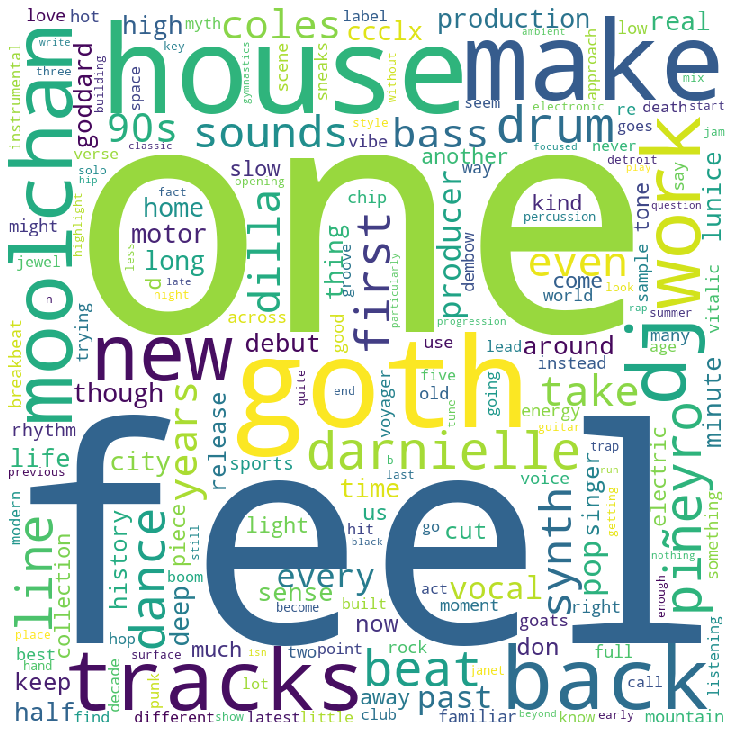

In [24]:
plotWordCloud(user_recs_p4k.head(10))

## Generate User Library Recommendations

**For all 3 users.**

**Danceability & Instrumentalness based on these showing many differences between our 3 libraries in Andres' analysis.**

**High values on these audio features: Look at the top 80% of these values to form user's search vector.**

**Vectorizing Done Below**

Loudness ranges from -60 to 0. In P4K and in our libraries, divide the loudness column by -60 to get decimals going 0 to 1.

Doing some research, it seems like high tempo songs are around 140-180. In P4K and in our libraries, divide the tempo column by 210 to get decimals going 0 to 1. Highest tempo in P4K is 193.24, Highest in libraries is 209.

Divide popularity by 100.

Regenerate user library vectors, album recommendations. Run the same analysis on these new albums.

Instrumentalness Data Set Generation:

In [25]:
# general settings for the search
audio_feat_sort = 'instrumentalness'
is_weighted = True
percent_above = 0.8
len_df = sp_p4k_2017_df.shape[0]


# For Anand ###############################################
user_df = our_tracks_by_users.get_group('Anand')
audio_feat_threshold = user_df[audio_feat_sort].quantile(percent_above) # top 20% of audio feature

# get the subset of library in top 20%
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
library_vector_high_instr_anand = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(library_vector_high_instr_anand)

# get our recommendations
alb_recs_high_instr_anand = P4K_Recommended_noFilter(library_vector_high_instr_anand, sp_p4k_2017_df)
alb_recs_high_instr_anand.insert(0, 'username', 'Anand')
# alb_recs_high_instr_anand.head(10)
# alb_recs_high_instr_anand.shape

# For Lina ###############################################
user_df = our_tracks_by_users.get_group('Lina')
audio_feat_threshold = user_df[audio_feat_sort].quantile(percent_above) # top 20% of audio feature

# get the subset of library in top 20%
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
library_vector_high_instr_lina = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(library_vector_high_instr_lina)

# get our recommendations
alb_recs_high_instr_lina = P4K_Recommended_noFilter(library_vector_high_instr_lina, sp_p4k_2017_df)
alb_recs_high_instr_lina.insert(0, 'username', 'Lina')

# alb_recs_high_instr_lina.head(10)

# For Andres ###############################################
user_df = our_tracks_by_users.get_group('Andres')
audio_feat_threshold = user_df[audio_feat_sort].quantile(percent_above) # top 20% of audio feature

# get the subset of library in top 20%
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
library_vector_high_instr_andres = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(library_vector_high_instr_andres)

# get our recommendations
alb_recs_high_instr_andres = P4K_Recommended_noFilter(library_vector_high_instr_andres, sp_p4k_2017_df)
alb_recs_high_instr_andres.insert(0, 'username', 'Andres')
# alb_recs_high_instr_andres.head(10)


{'popularity': {'average_value': 0.25675000000000003, 'weight': 3.228085939034585}, 'danceability': {'average_value': 0.37842375, 'weight': 3.6873808648722557}, 'energy': {'average_value': 0.4363949999999999, 'weight': 3.251429641208101}, 'loudness': {'average_value': 0.2401264583333333, 'weight': 4.796291239512726}, 'speechiness': {'average_value': 0.055125, 'weight': 2.900558372879952}, 'acousticness': {'average_value': 0.59282982375, 'weight': 3.1008222939663517}, 'instrumentalness': {'average_value': 0.929, 'weight': 67.10236556732758}, 'liveness': {'average_value': 0.16612375000000004, 'weight': 2.6046414317083193}, 'valence': {'average_value': 0.25517124999999996, 'weight': 2.148289808765208}, 'tempo': {'average_value': 0.5468140476190474, 'weight': 7.180134840724922}}
{'popularity': {'average_value': 0.40187500000000015, 'weight': 8.111571131895893}, 'danceability': {'average_value': 0.5917749999999999, 'weight': 17.98427979098771}, 'energy': {'average_value': 0.60686125, 'weigh

In [26]:
alb_recs_high_instr_anand.head(50)

,username,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
265,Anand,spotify:album:1yc17D4aHQRfltXlln9Mcq,Chalice Hymnal,Grails,0.5027,0.3263,0.5122,0.8995,0.1901,0.2189,...,3019362,0,Grails,0,February 25 2017,Metal,"On the follow-up to 2011’s Deep Politics, the ...",7.7000,underrated,0.3896
615,Anand,spotify:album:4MV07ok2E7O0ILN7qVsGAA,The Imperfect Sea,Penguin Cafe,0.5843,0.4290,0.3799,0.8697,0.1312,0.2658,...,3000220,0,Penguin Cafe,0,May 11 2017,Experimental,Simon Jeffes’ Penguin Cafe Orchestra were char...,6.4000,ignorables,0.5300
740,Anand,spotify:album:5IQhNr6Vn3cq03bPty6Cpe,All This I Do for Glory,Colin Stetson,0.6233,0.3853,0.5037,0.8990,0.1212,0.2336,...,2615432,0,Colin Stetson,0,May 2 2017,Experimental,"On his latest solo album, the breathless saxop...",7.1000,ignorables,0.5673
296,Anand,spotify:album:29MU5A39NfSLiCN6pjtGcn,Symbolic Use of Light,UMFANG,0.6908,0.6279,0.4664,0.9351,0.1045,0.3067,...,2510019,0,UMFANG,0,June 17 2017,Electronic,"The Kansas-bred, New York-based DJ has been st...",7.8000,underrated,0.6034
786,Anand,spotify:album:5d1hWmBYkAkVAE9XG5njrz,Stranger Things 2 (A Netflix Original Series S...,Kyle Dixon / Michael Stein,0.7907,0.3464,0.2824,0.8990,0.1185,0.3476,...,4165580,0,Kyle Dixon / Michael Stein,0,November 1 2017,Electronic,The heady electronic duo that gave Netflix’s s...,7.2000,ignorables,0.6051
289,Anand,spotify:album:27V59X3laD1ALzNpwXyMKB,EP #260,SQÜRL,0.4548,0.4305,0.5482,0.8980,0.1758,0.2057,...,1720791,0,SQÜRL,0,July 19 2017,Experimental,"With his band SQÜRL, the legendary filmmaker J...",6.8000,ignorables,0.6149
381,Anand,spotify:album:2lacbSVN1I2w7om2tHIT4K,Body Consonance,Byron Westbrook,0.6284,0.2338,0.3728,0.8994,0.2266,0.2897,...,2180922,0,Byron Westbrook,0,October 18 2017,Experimental,In a departure from the spatial concerns of hi...,7.7000,underrated,0.6236
997,Anand,spotify:album:7CrQDntlruI4Tb2yRiDpQZ,Gifts From the Ebb Tide,Coupler,0.4085,0.4273,0.4233,0.9393,0.0963,0.3093,...,1997720,0,Coupler,0,November 20 2017,Electronic,The third studio album from Coupler lays out a...,7.1000,ignorables,0.6430
128,Anand,spotify:album:10A2Lh9WyT4wNTGl2Ipa77,Bay Head,Gunn-Truscinski Duo,0.7860,0.2971,0.3259,0.8880,0.1123,0.2802,...,2275641,0,Gunn-Truscinski Duo,0,November 4 2017,Experimental,Steve Gunn and John Truscinski’s third album o...,7.5000,underrated,0.6521
902,Anand,spotify:album:6XmX3zflDoS8NWEEQQD9p4,Stone Garden,Kikagaku Moyo,0.5419,0.2354,0.6590,0.9036,0.1856,0.1861,...,1760100,0,Kikagaku Moyo,0,May 27 2017,Experimental,"In the clubs of Tokyo, psych-rockers Kikagaku ...",6.0000,ignorables,0.6598


In [27]:
alb_recs_high_instr_lina.head(50)

,username,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
442,Lina,spotify:album:39dY6cEFXDEevnfUTzp6lZ,Boo Boo,Toro Y Moi,0.4103,0.5778,0.6183,0.2426,0.1527,0.1407,...,2955709,0,Toro Y Moi,0,July 11 2017,Electronic,Toro Y Moi’s Chaz Bear sounds increasingly com...,6.9000,overrated,0.3957
911,Lina,spotify:album:6cuNyrSmRjBeekioLdLkvI,Ray of Light,Madonna,0.3635,0.5582,0.5897,0.2884,0.1085,0.1871,...,4004716,0,Madonna,0,August 16 2017,Pop/R&B,"Channeling acid electronica, Kabbalah, and mot...",8.1000,favorites,0.4494
273,Lina,spotify:album:22sKyWyE7QGrAtfPHDboXV,Belong,San Fermin,0.2119,0.5834,0.6409,0.3099,0.1176,0.1238,...,2608771,0,San Fermin,0,April 19 2017,Rock,The third album from studied Brooklyn chamber-...,5.8000,overrated,0.5857
780,Lina,spotify:album:5bCk3kWAy2JbbTfHqzZCII,"Passion, Pain & Demon Slayin’",Kid Cudi,0.2771,0.6437,0.6203,0.1970,0.1682,0.1376,...,5219221,11,Kid Cudi,0,December 20 2016,Rap,"Scott Mescudi’s latest tome, the 87-minute **P...",6.7000,overrated,0.5884
1051,Lina,spotify:album:7vHBQDqwzB7uDvoE5bncMM,Drunk,Thundercat,0.5275,0.5919,0.5722,0.2432,0.1535,0.1730,...,2965610,7,Thundercat,1,February 27 2017,Jazz,Best new music The third album from bassist/so...,8.5000,favorites,0.6525
359,Lina,spotify:album:2bhZ63lO9MbdvDfI9S5pRm,A Place I’ll Always Go,Palehound,0.3080,0.5720,0.5669,0.3630,0.2037,0.1386,...,1618912,0,Palehound,0,June 23 2017,Rock,"On her second album, Boston singer-songwriter ...",7.3000,underrated,0.6599
572,Lina,spotify:album:45CvmoLWs7OKLnWr5kBR9s,Lune Rouge,TOKiMONSTA,0.3159,0.6267,0.6809,0.3944,0.2025,0.1088,...,2345129,1,TOKiMONSTA,0,October 17 2017,Electronic,The Los Angeles electronic musician rebounds f...,6.8000,overrated,0.6855
403,Lina,spotify:album:2vTelM2ZV20cLPqQwfWhYa,Dots and Loops,Stereolab,0.4038,0.5759,0.5274,0.4300,0.1382,0.1834,...,6277297,0,Stereolab,0,July 23 2017,Experimental,Stereolab’s masterpiece fused analog with digi...,9.2000,favorites,0.6939
401,Lina,spotify:album:2vBwQxoey9MJ7CApSpGya9,City Music,Kevin Morby,0.3739,0.5666,0.5447,0.1271,0.1752,0.1598,...,2887249,0,Kevin Morby,0,June 21 2017,Rock,Kevin Morby’s captivating fourth album feels s...,8.1000,favorites,0.7049
758,Lina,spotify:album:5RKLyPZ4P8WhO1uxDMXGe7,Content,Joywave,0.2248,0.5396,0.6259,0.1420,0.1460,0.1562,...,2420229,0,Joywave,0,August 4 2017,Rock,The second album from the synth-pop group find...,5.9000,overrated,0.7090


In [28]:
alb_recs_high_instr_andres.head(50)

,username,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
296,Andres,spotify:album:29MU5A39NfSLiCN6pjtGcn,Symbolic Use of Light,UMFANG,0.6908,0.6279,0.4664,0.9351,0.1045,0.3067,...,2510019,0,UMFANG,0,June 17 2017,Electronic,"The Kansas-bred, New York-based DJ has been st...",7.8000,underrated,0.4909
569,Andres,spotify:album:44CLAUpVvtb5izbJ0nZfUt,Plant Age,Terekke,0.6897,0.6612,0.3392,0.9143,0.1091,0.3466,...,1536714,0,Terekke,0,November 29 2017,Electronic,"On his debut album, the L.I.E.S. mainstay make...",7.9000,underrated,0.5552
615,Andres,spotify:album:4MV07ok2E7O0ILN7qVsGAA,The Imperfect Sea,Penguin Cafe,0.5843,0.4290,0.3799,0.8697,0.1312,0.2658,...,3000220,0,Penguin Cafe,0,May 11 2017,Experimental,Simon Jeffes’ Penguin Cafe Orchestra were char...,6.4000,ignorables,0.5588
265,Andres,spotify:album:1yc17D4aHQRfltXlln9Mcq,Chalice Hymnal,Grails,0.5027,0.3263,0.5122,0.8995,0.1901,0.2189,...,3019362,0,Grails,0,February 25 2017,Metal,"On the follow-up to 2011’s Deep Politics, the ...",7.7000,underrated,0.5982
431,Andres,spotify:album:34ynU7YpurAxR383tfswdl,Ariadna,Kedr Livanskiy,0.3980,0.4824,0.6116,0.8634,0.1609,0.1964,...,2558244,0,Kedr Livanskiy,0,September 7 2017,Electronic,"Working with classic hardware synths, the Russ...",7.4000,favorites,0.6186
743,Andres,spotify:album:5JUH7myqO5ffIso1c7LTc2,Taster,Hovvdy,0.5617,0.5746,0.4629,0.8610,0.1276,0.1324,...,1121014,0,Hovvdy,0,April 19 2017,Rock,The minimal Austin duo Hovvdy stack simple rif...,7.3000,underrated,0.6340
289,Andres,spotify:album:27V59X3laD1ALzNpwXyMKB,EP #260,SQÜRL,0.4548,0.4305,0.5482,0.8980,0.1758,0.2057,...,1720791,0,SQÜRL,0,July 19 2017,Experimental,"With his band SQÜRL, the legendary filmmaker J...",6.8000,ignorables,0.6384
997,Andres,spotify:album:7CrQDntlruI4Tb2yRiDpQZ,Gifts From the Ebb Tide,Coupler,0.4085,0.4273,0.4233,0.9393,0.0963,0.3093,...,1997720,0,Coupler,0,November 20 2017,Electronic,The third studio album from Coupler lays out a...,7.1000,ignorables,0.6389
932,Andres,spotify:album:6llrFan1q8MsbOFkwytoCC,Voices Bloom,James Place,0.4376,0.5316,0.5103,0.8790,0.1413,0.2245,...,2446666,0,James Place,0,May 26 2017,None,The new album from electronic artist Phil Tort...,7.4000,underrated,0.6396
786,Andres,spotify:album:5d1hWmBYkAkVAE9XG5njrz,Stranger Things 2 (A Netflix Original Series S...,Kyle Dixon / Michael Stein,0.7907,0.3464,0.2824,0.8990,0.1185,0.3476,...,4165580,0,Kyle Dixon / Michael Stein,0,November 1 2017,Electronic,The heady electronic duo that gave Netflix’s s...,7.2000,ignorables,0.7059


Danceability Generation

In [29]:
# general settings for the search
audio_feat_sort = 'danceability'
is_weighted = True
percent_above = 0.8

# For Anand ###############################################
user_df = our_tracks_by_users.get_group('Anand')
audio_feat_threshold = user_df[audio_feat_sort].quantile(percent_above) # top 20% of audio feature

# get the subset of library in top 20%
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
library_vector_high_danc_anand = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(library_vector_high_danc_anand)

# get our recommendations
alb_recs_high_danc_anand = P4K_Recommended_noFilter(library_vector_high_danc_anand, sp_p4k_2017_df)
alb_recs_high_danc_anand.insert(0, 'username', 'Anand')
# alb_recs_high_danc_anand.head(10)
# alb_recs_high_instr_anand.shape

# For Lina ###############################################
user_df = our_tracks_by_users.get_group('Lina')
audio_feat_threshold = user_df[audio_feat_sort].quantile(percent_above) # top 20% of audio feature

# get the subset of library in top 20%
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
library_vector_high_danc_lina = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(library_vector_high_danc_lina)

# get our recommendations
alb_recs_high_danc_lina = P4K_Recommended_noFilter(library_vector_high_danc_lina, sp_p4k_2017_df)
alb_recs_high_danc_lina.insert(0, 'username', 'Lina')
# alb_recs_high_danc_lina.head(10)

# For Andres ###############################################
user_df = our_tracks_by_users.get_group('Andres')
audio_feat_threshold = user_df[audio_feat_sort].quantile(percent_above) # top 20% of audio feature

# get the subset of library in top 20%
user_df_filtered = user_df[user_df[audio_feat_sort] > audio_feat_threshold]

# get our library vector
library_vector_high_danc_andres = get_library_vector_noFilter(user_df_filtered, is_weighted)
print(library_vector_high_danc_andres)

# get our recommendations
alb_recs_high_danc_andres = P4K_Recommended_noFilter(library_vector_high_danc_andres, sp_p4k_2017_df)
alb_recs_high_danc_andres.insert(0, 'username', 'Andres')
# alb_recs_high_danc_andres.head(10)


{'popularity': {'average_value': 0.32275000000000004, 'weight': 5.744851416185976}, 'danceability': {'average_value': 0.7338374999999997, 'weight': 32.90012949016502}, 'energy': {'average_value': 0.6058375, 'weight': 10.74122295750071}, 'loudness': {'average_value': 0.16539229166666664, 'weight': 9.007850012555593}, 'speechiness': {'average_value': 0.06798500000000002, 'weight': 3.8077540168400175}, 'acousticness': {'average_value': 0.30851560375000003, 'weight': 3.0797235335159137}, 'instrumentalness': {'average_value': 0.484061360125, 'weight': 4.189510650557332}, 'liveness': {'average_value': 0.13887750000000001, 'weight': 4.762552540526898}, 'valence': {'average_value': 0.5023762499999997, 'weight': 6.1671528107248506}, 'tempo': {'average_value': 0.5853281547619046, 'weight': 19.599252571427677}}
{'popularity': {'average_value': 0.5432500000000002, 'weight': 6.267107434523791}, 'danceability': {'average_value': 0.812275, 'weight': 41.86560350768144}, 'energy': {'average_value': 0.6

In [30]:
alb_recs_high_danc_anand.head(50)

,username,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
460,Anand,spotify:album:3IbY6WzMWrPx7ZnqMfEkd6,Electric Lines,Joe Goddard,0.1833,0.6982,0.5178,0.4103,0.1235,0.1824,...,4252198,0,Joe Goddard,0,April 17 2017,Electronic,The Hot Chip founding member’s first official ...,7.2000,overrated,0.5137
28,Anand,spotify:album:0CZ8vYh13Jl7h9xNmfNGL6,Voyager,Vitalic,0.0472,0.7118,0.6648,0.5049,0.1908,0.1197,...,2515246,0,Vitalic,0,January 26 2017,Electronic,There are glimpses of Vitalic's old energy on ...,5.4000,overrated,0.6092
77,Anand,spotify:album:0d6ky7EGJ0DBxCsSR9R5SR,Take Flight,Maya Jane Coles,0.2233,0.7122,0.7256,0.6971,0.1646,0.1211,...,6436775,1,Maya Jane Coles,0,August 23 2017,Electronic,The first major release in three years from Br...,6.0000,overrated,0.6631
896,Anand,spotify:album:6VTTkMIKHhmFsZkKXsvS5I,Goths,The Mountain Goats,0.5085,0.6907,0.4711,0.4061,0.1422,0.2100,...,3307782,0,The Mountain Goats,0,May 22 2017,Rock,John Darnielle's latest is a richly detailed c...,8.0000,favorites,0.6868
120,Anand,spotify:album:0v9TomxoVagPyvVNGhDbyB,Motor City,J Dilla,0.2381,0.7143,0.6046,0.6306,0.1934,0.1448,...,1947266,0,J Dilla,0,April 20 2017,Rap,This set of rare and unreleased Dilla instrume...,6.8000,overrated,0.7277
915,Anand,spotify:album:6dfVH3U3qwJ7Cd8LgGL9wb,It's a Myth,Sneaks,0.3042,0.7543,0.4574,0.6505,0.1084,0.2098,...,1124929,0,Sneaks,0,March 27 2017,Rock,"Using just a bass and a drum machine, Eva Mool...",7.3000,underrated,0.7615
679,Anand,spotify:album:4sZvkjrogy7HbQ0M5CNCEL,Modern Species,DJ Sports,0.1689,0.7254,0.6701,0.7259,0.1850,0.1747,...,2544778,0,DJ Sports,0,June 15 2017,Electronic,Denmark’s DJ Sports makes experimental dance m...,7.8000,underrated,0.7749
793,Anand,spotify:album:5ed88vlnRUnfNnqECEohSt,Real High,Nite Jewel,0.2532,0.6468,0.5149,0.3846,0.1131,0.1340,...,2460094,0,Nite Jewel,0,May 10 2017,Pop/R&B,Ramona Gonzalez digs back into the ’90s to fin...,7.5000,underrated,0.8179
617,Anand,spotify:album:4Me0UCcfE961pDkGPWjg7J,CCCLX,Lunice,0.1676,0.6745,0.5893,0.3685,0.1012,0.1698,...,2459566,0,Lunice,0,September 13 2017,Electronic,The debut LP from Montreal producer Lunice (on...,5.7000,ignorables,0.8307
348,Anand,spotify:album:2YATBIuFHzwSZOfHcEG2Ns,Dulce Compañia,DJ Python,0.2179,0.6778,0.6790,0.7717,0.1292,0.1682,...,2951265,0,DJ Python,0,September 25 2017,Electronic,"On his full-length debut, the versatile Queens...",7.6000,underrated,0.8410


In [31]:
alb_recs_high_danc_lina.head(50)

,username,album_uri,album,album_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,...,duration_ms,is_explicit,artist,best,date,genre,review,score,group_label,distance
244,Lina,spotify:album:1qyjZGIeeLJlXbYWuoloWj,Nervous System,Julia Michaels,0.2761,0.7610,0.5250,0.0007,0.0966,0.1200,...,1314264,2,Julia Michaels,0,August 4 2017,Pop/R&B,After penning hits for Selena Gomez and Hailee...,6.6000,overrated,0.5136
262,Lina,spotify:album:1xQq0txMTpstjFUwp4c4E0,Automaton,Jamiroquai,0.0542,0.7877,0.6933,0.0456,0.0844,0.1241,...,3427516,0,Jamiroquai,0,April 4 2017,Jazz,The British dance-funk group return with their...,7.0000,overrated,0.5267
1027,Lina,spotify:album:7gGdhlPptWrRYPXZw3j8dS,"Laugh Now, Fly Later",Wiz Khalifa,0.1269,0.8032,0.6513,0.0000,0.1771,0.1128,...,2403893,10,Wiz Khalifa,0,November 15 2017,Rap,"Across a relatively lean, stakes-free mixtape,...",5.2000,overrated,0.5484
341,Lina,spotify:album:2VVvm4zJlUQm9XmBCvGN6z,Lil Pump,Lil Pump,0.1109,0.8677,0.5511,0.0000,0.1516,0.1168,...,2206871,15,Lil Pump,0,October 12 2017,Rap,"Lil Pump’s debut is loud, hyper, and catchy. T...",6.9000,overrated,0.5524
353,Lina,spotify:album:2aTOwGU66ocsf8IQpOI0XZ,Mr. Davis,Gucci Mane,0.1086,0.8142,0.6119,0.0002,0.1367,0.0997,...,3672298,17,Gucci Mane,0,October 19 2017,Rap,Seventeen months since his release from prison...,7.4000,favorites,0.5759
114,Lina,spotify:album:0tKX7BLXiiRgXUKYdJzjEz,A Love Letter to You 2,Trippie Redd,0.3828,0.7555,0.5655,0.0001,0.2036,0.1086,...,3548361,21,Trippie Redd,0,October 16 2017,Rap,Ohio rapper Trippie Redd’s second mixtape this...,6.4000,overrated,0.6043
974,Lina,spotify:album:72qA6s4fjF8Y2VX1UDMfp2,Gemini,Macklemore,0.2150,0.7314,0.5686,0.0001,0.1226,0.1279,...,3618011,12,Macklemore,0,September 26 2017,Rap,Macklemore’s new album is a light listen with ...,5.4000,overrated,0.6243
825,Lina,spotify:album:5v7Icroz1sQsK2sQyLrWzE,Country Grammar,Nelly,0.0766,0.8406,0.6680,0.0005,0.2971,0.1076,...,3844150,14,Nelly,0,September 3 2017,Rap,Nelly’s 2000 debut brought the life and sound ...,8.1000,favorites,0.6292
336,Lina,spotify:album:2TWKabrKN6YOZ1jgqo97uz,DEADSTAR,Smokepurpp,0.1570,0.8294,0.6072,0.0012,0.1650,0.1079,...,2902772,18,Smokepurpp,0,October 11 2017,Rap,"On his debut album, the 20-year-old Florida ra...",6.2000,overrated,0.6717
678,Lina,spotify:album:4rJgzzfFHAVFhCSt2P4I3j,Playboi Carti,Playboi Carti,0.1298,0.7915,0.6015,0.0000,0.2635,0.1016,...,2816261,15,Playboi Carti,0,April 22 2017,Rap,The young Atlanta rapper’s debut mixtape finds...,7.3000,favorites,0.6807


In [32]:
alb_recs_high_danc_andres.head(50)
sp_p4k_2017_df.shape[0]

1063

## Save our album recommendations to CSVs

In [33]:
# save combined albums to csv
alb_recs_high_danc_anand.to_csv("alb_recs_high_danc_anand_vec.csv", encoding="utf-8-sig")
alb_recs_high_danc_lina.to_csv("alb_recs_high_danc_lina_vec.csv", encoding="utf-8-sig")
alb_recs_high_danc_andres.to_csv("alb_recs_high_danc_andres_vec.csv", encoding="utf-8-sig")

alb_recs_high_instr_anand.to_csv("alb_recs_high_instr_anand_vec.csv", encoding="utf-8-sig")
alb_recs_high_instr_lina.to_csv("alb_recs_high_instr_lina_vec.csv", encoding="utf-8-sig")
alb_recs_high_instr_andres.to_csv("alb_recs_high_instr_andres_vec.csv", encoding="utf-8-sig")